# Modern Data Analytics Report 2022 - Eurovision

### Report by:

Viktoria Kirichenko (0877202) <br>
Jack Heller (   ) <br>
Elizabeth Vadakkekalam (   )<br>
Medha Hegde (0872802)<br>
Josiah McMillan (    )<br>





# Table of contents
1. [Cypher - Neo4j](#neo4j)<br>
    1.1 [Loading Data](#loading)<br>
    1.2 [Exploring the Data](#exploring)<br>
    1.3 [Centrality Measures](#centrality)<br>
    1.4 [Community Detection using Louvain](#community)
2. [Song Sentiment Analysis](#sentiment)
3. [Predicting the 2022 Winner](#prediction)



In [1]:
import pandas as pd
import numpy as np
import lxml
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from textblob import TextBlob
import nltk 
from nltk.corpus import stopwords

import requests
import lxml.html as lh
from bs4 import BeautifulSoup
from sklearn.metrics import mean_squared_error

ModuleNotFoundError: No module named 'wordcloud'

# Cypher- Neo4j <a name="neo4j"></a>

The following method of incorperating cypher code into pythod was found on "Towards Data Science" by Shuyi Yang.


In [2]:
pip install neo4j

  Created wheel for neo4j: filename=neo4j-4.4.4-py3-none-any.whl size=116330 sha256=aca179d69c56502330e7406e9a18bdcb61d166b364c537cb53b57c3e5ba16d66
  Stored in directory: c:\users\eliza\appdata\local\pip\cache\wheels\9d\b9\b8\570e01eacec0e57cc6bd070b79eeab917f83a00b8b090eb66f
Successfully built neo4j
Note: you may need to restart the kernel to use updated packages.


In [3]:
from neo4j import __version__ as neo4j_version
print(neo4j_version)

4.4.4


In [4]:
from neo4j import GraphDatabase

Before starting please do the following:

- (create) and start a database in neo4j

- open the database and select the database information on the left side

- click on "Admin:server user add"

- create a user with the name "MDA", Password "MDA" and role "Admin"

You are now all set.


In [3]:
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

For the next line, make sure you have the same Local Host 

In [4]:
conn = Neo4jConnection(uri="bolt://localhost:7687", user="MDA", pwd="MDA")

In [5]:
conn.query("CREATE OR REPLACE DATABASE coradb")

[]

Making sure that there are no Nodes and Relationships in the Database

In [6]:
query_string = '''
MATCH(n) DETACH DELETE n
'''
conn.query(query_string, db='coradb')

[]

## Loading the Nodes and Relationships (based on Data from 2012-2015)   <a name="loading"></a>

In [5]:
import requests

url = "https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/rawNeoData.txt"
file = requests.get(url)

In [8]:
query_string = file.text
conn.query(query_string, db='coradb')

[]

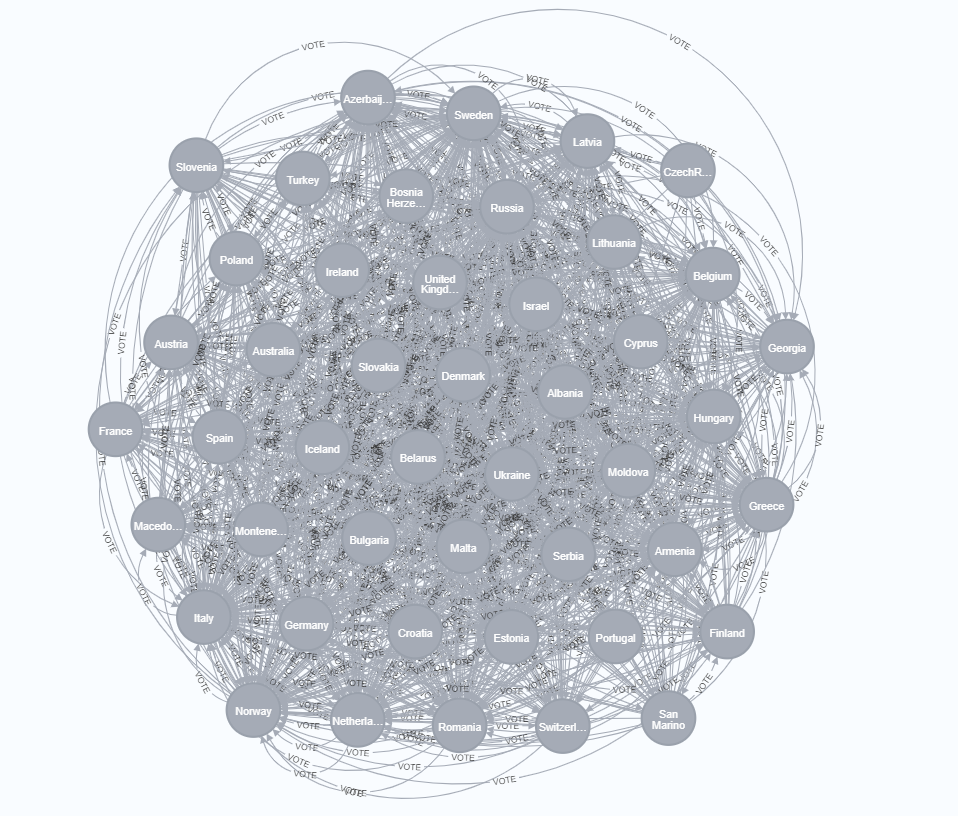

## Exploring the Data <a name="exploring"></a>

#### Which country received the highest sum of scores over these years

In [9]:
query_string = '''
MATCH (from:Country)-[v]->(to:Country)
RETURN to.name, sum(v.score) as totalScore
ORDER BY totalScore DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record to.name='Sweden' totalScore=1008>,
 <Record to.name='Russia' totalScore=827>,
 <Record to.name='Italy' totalScore=555>,
 <Record to.name='Azerbaijan' totalScore=466>,
 <Record to.name='Ukraine' totalScore=392>,
 <Record to.name='Norway' totalScore=382>,
 <Record to.name='Denmark' totalScore=371>,
 <Record to.name='Netherlands' totalScore=342>,
 <Record to.name='Belgium' totalScore=288>,
 <Record to.name='Austria' totalScore=278>]

####  Adding up all votes from all year from country a to country b

In [10]:
query_string = '''
MATCH (from:Country)-[v]->(to:Country)
WITH from, to, sum(v.score) as totalvotes
MERGE (from)-[r:VOTES_ALL {total:totalvotes}]->(to)
RETURN from.name, to.name,totalvotes
ORDER BY totalvotes DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record from.name='Moldova' to.name='Romania' totalvotes=46>,
 <Record from.name='Denmark' to.name='Sweden' totalvotes=44>,
 <Record from.name='Belarus' to.name='Russia' totalvotes=44>,
 <Record from.name='Norway' to.name='Sweden' totalvotes=44>,
 <Record from.name='Malta' to.name='Italy' totalvotes=42>,
 <Record from.name='Albania' to.name='Italy' totalvotes=41>,
 <Record from.name='Georgia' to.name='Azerbaijan' totalvotes=39>,
 <Record from.name='Finland' to.name='Sweden' totalvotes=38>,
 <Record from.name='Latvia' to.name='Sweden' totalvotes=36>,
 <Record from.name='Slovenia' to.name='Sweden' totalvotes=36>]

#### Which country received 12 points from other countries most often

In [11]:
query_string = '''
MATCH (from:Country)-[v:VOTE{score:12}]->(to:Country)
RETURN to.name, count(v.score) as MaxPoints
ORDER BY MaxPoints DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record to.name='Sweden' MaxPoints=34>,
 <Record to.name='Azerbaijan' MaxPoints=16>,
 <Record to.name='Italy' MaxPoints=13>,
 <Record to.name='Austria' MaxPoints=12>,
 <Record to.name='Russia' MaxPoints=10>,
 <Record to.name='Netherlands' MaxPoints=9>,
 <Record to.name='Denmark' MaxPoints=8>,
 <Record to.name='Albania' MaxPoints=5>,
 <Record to.name='Ukraine' MaxPoints=5>,
 <Record to.name='Serbia' MaxPoints=5>]

#### Which country received 1 point from other countries most often. Sweden seems to be the most popular country.

In [12]:
query_string = '''
MATCH (from:Country)-[v:VOTE {score:1}]->(to:Country)
RETURN to.name, count(v.score) as MinPoints
ORDER BY MinPoints DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record to.name='Greece' MinPoints=9>,
 <Record to.name='Ukraine' MinPoints=8>,
 <Record to.name='Spain' MinPoints=8>,
 <Record to.name='Hungary' MinPoints=8>,
 <Record to.name='Romania' MinPoints=8>,
 <Record to.name='United Kingdom' MinPoints=7>,
 <Record to.name='Italy' MinPoints=7>,
 <Record to.name='Denmark' MinPoints=7>,
 <Record to.name='Lithuania' MinPoints=6>,
 <Record to.name='Norway' MinPoints=5>]

####  Looking at the influence of neighbors on the votes
- Inspiration and Data from https://memgraph.com/blog/analyzing-the-eurovision-song-contest-with-graphs


In [13]:
query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/GEODATASOURCE-COUNTRY-BORDERS.csv" AS row  

  

MATCH (FromCountry:Country {name: row.country_name})  

  

MATCH (ToCountry:Country {name: row.country_border_name})  

  

CREATE (FromCountry)-[B:BORDER]->(ToCountry); 

 
'''
conn.query(query_string, db='coradb')

[]

#### How many neighbors do the countries have? We expect more bias in neighboring countries

In [14]:
query_string = '''
MATCH (c1:Country)-[r:BORDER]-(c2:Country)
WITH DISTINCT c2.name AS Neighbor, c1.name as Country
RETURN Country, COUNT(Neighbor) AS Number_of_neighbors
ORDER BY Number_of_neighbors DESC LIMIT 10;
'''
conn.query(query_string, db='coradb')

[<Record Country='Russia' Number_of_neighbors=10>,
 <Record Country='Hungary' Number_of_neighbors=7>,
 <Record Country='Germany' Number_of_neighbors=7>,
 <Record Country='Serbia' Number_of_neighbors=6>,
 <Record Country='Poland' Number_of_neighbors=6>,
 <Record Country='Ukraine' Number_of_neighbors=6>,
 <Record Country='Austria' Number_of_neighbors=6>,
 <Record Country='Italy' Number_of_neighbors=5>,
 <Record Country='Belarus' Number_of_neighbors=5>,
 <Record Country='Turkey' Number_of_neighbors=5>]

Looking at the ESC 2012, where the top 3 were Sweden, Russia and Serbia
- How much of the votes are coming from direct neighbors of a country?

In [15]:
query_string = '''

MATCH (c1:Country)-[b:BORDER ]-(c2:Country {name: 'Sweden'}),
      (c1:Country)-[v:VOTE {year: 2012}]->(c2:Country)
WITH sum(v.score) AS border_vote, c2.name AS name
MATCH (:Country)-[v:VOTE {year: 2012} ]->(c:Country {name: 'Sweden'})
RETURN v.year, c.name AS Country, sum(v.score) AS Points, sum(v.score)-border_vote AS Points_without_neighbours;
'''
conn.query(query_string, db='coradb')


[<Record v.year=2012 Country='Sweden' Points=372 Points_without_neighbours=324>]

In [16]:
query_string = '''

MATCH (c1:Country)-[b:BORDER ]-(c2:Country {name: 'Serbia'}),
      (c1:Country)-[v:VOTE {year: 2012}]->(c2:Country)
WITH sum(v.score) AS border_vote, c2.name AS name
MATCH (:Country)-[v:VOTE {year: 2012} ]->(c:Country {name: 'Serbia'})
RETURN v.year, c.name AS Country, sum(v.score) AS Points, sum(v.score)-border_vote AS Points_without_neighbours;
'''
conn.query(query_string, db='coradb')

[<Record v.year=2012 Country='Serbia' Points=214 Points_without_neighbours=122>]

In [17]:
query_string = '''

MATCH (c1:Country)-[b:BORDER ]-(c2:Country {name: 'Russia'}),
      (c1:Country)-[v:VOTE {year: 2012}]->(c2:Country)
WITH sum(v.score) AS border_vote, c2.name AS name
MATCH (:Country)-[v:VOTE {year: 2012} ]->(c:Country {name: 'Russia'})
RETURN v.year, c.name AS Country, sum(v.score) AS Points, sum(v.score)-border_vote AS Points_without_neighbours;
'''
conn.query(query_string, db='coradb')


[<Record v.year=2012 Country='Russia' Points=259 Points_without_neighbours=105>]

While Russia and Serbia clearly have more neighbors than Sweden, at first glance it still seems like eastern european countries show more dependence on votes from neighbors 

## Centrality Measures <a name="centrality"></a>

- Degree Centrality 
- Betweenness Centrality 


Methods are based on Neo4j documentation from

https://neo4j-website.s3.eu-central-1.amazonaws.com/build/html/Algorithms/centrality/centrality.html and 

https://neo4j.com/docs/graph-data-science/current/algorithms/centrality/ 

Storing the Graph before using it, the orientation is set to "UNDIRECTED" since this is appropriate for our relationship structure

In [18]:
query_string = '''
CALL gds.graph.project( 

  'myGraph4', 

  'Country', 

  { 

    VOTE: { 

      orientation: 'UNDIRECTED', 

      properties: ['score'] 

    } 

  } 

) 
'''
conn.query(query_string, db='coradb')

[<Record nodeProjection={'Country': {'label': 'Country', 'properties': {}}} relationshipProjection={'VOTE': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'VOTE', 'properties': {'score': {'defaultValue': None, 'property': 'score', 'aggregation': 'DEFAULT'}}}} graphName='myGraph4' nodeCount=46 relationshipCount=3140 projectMillis=40>]

### Degree Centrality
Goal: find out about the popularity of the countries 

#### First without using the scores countries gave one-another as weight

In [19]:
query_string = '''
CALL gds.degree.stream('myGraph4') 

YIELD nodeId, score 

RETURN gds.util.asNode(nodeId).name AS name, score AS Voters 

ORDER BY Voters DESC, name DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record name='Sweden' Voters=162.0>,
 <Record name='Russia' Voters=157.0>,
 <Record name='Italy' Voters=129.0>,
 <Record name='Norway' Voters=117.0>,
 <Record name='Azerbaijan' Voters=103.0>,
 <Record name='Denmark' Voters=100.0>,
 <Record name='Greece' Voters=94.0>,
 <Record name='Ukraine' Voters=93.0>,
 <Record name='Belgium' Voters=92.0>,
 <Record name='Hungary' Voters=91.0>]

#### Now using the scores as weights 

In [20]:

query_string = '''
CALL gds.degree.stream( 

   'myGraph4', 

   { relationshipWeightProperty: 'score' } 

) 

YIELD nodeId, score 

RETURN gds.util.asNode(nodeId).name AS name, score AS weightedVoters 

ORDER BY weightedVoters DESC, name DESC LIMIT 10
'''
conn.query(query_string, db='coradb')


[<Record name='Sweden' weightedVoters=1240.0>,
 <Record name='Russia' weightedVoters=1059.0>,
 <Record name='Italy' weightedVoters=787.0>,
 <Record name='Azerbaijan' weightedVoters=698.0>,
 <Record name='Norway' weightedVoters=614.0>,
 <Record name='Denmark' weightedVoters=603.0>,
 <Record name='Netherlands' weightedVoters=576.0>,
 <Record name='Ukraine' weightedVoters=566.0>,
 <Record name='Belgium' weightedVoters=520.0>,
 <Record name='Austria' weightedVoters=510.0>]

- The top 3 popular countries: Sweden, Russia and Italy stay the same, regardless of whether weights are used, the following countries change slightly
- We expect the results to be more representative when incorperating scores as weights, since giving a country 1 point is not the same as giving a country 12 points


### Betweenness Centrality
Goal: find out which countries acts as a "middleman"

In [21]:

query_string = '''
CALL gds.betweenness.stream('myGraph4') 

YIELD nodeId, score 

RETURN gds.util.asNode(nodeId).name AS name, score 

ORDER BY score DESC, name DESC LIMIT 10
'''
conn.query(query_string, db='coradb')

[<Record name='Sweden' score=50.592211724898064>,
 <Record name='Russia' score=44.74215714388414>,
 <Record name='Italy' score=30.61950544867462>,
 <Record name='Azerbaijan' score=24.007583652577473>,
 <Record name='Hungary' score=13.931313030363901>,
 <Record name='Serbia' score=12.919201806760698>,
 <Record name='Norway' score=11.738872402452678>,
 <Record name='Greece' score=10.652986782911995>,
 <Record name='Belgium' score=9.097551536115134>,
 <Record name='Spain' score=8.427649986480889>]

Again, the top 3 countries do not change. Hungary seems to be a country which is more of a "middleman" than a very popular country in eurovision

- We are not using closeness centrality since for us it is less important to see which countries spread information through the ESC
- We are not using PageRank since our graph is not directed

## Community Detection using Louvain <a name="community"></a>

First we are storing the graph

In [22]:

query_string = '''
CALL gds.graph.project( 

    'myGraph5', 

    'Country', 

    { 

        VOTE: { 

            orientation: 'UNDIRECTED' 

        } 

    }, 

    { 

        relationshipProperties: 'score' 

    } 

) 

'''
conn.query(query_string, db='coradb')

[<Record nodeProjection={'Country': {'label': 'Country', 'properties': {}}} relationshipProjection={'VOTE': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'VOTE', 'properties': {'score': {'defaultValue': None, 'property': 'score', 'aggregation': 'DEFAULT'}}}} graphName='myGraph5' nodeCount=46 relationshipCount=3140 projectMillis=36>]

#### Creating communities based on voting patterns, not incoperating scores as weights. Saving the output as a dataframe

In [24]:

query_string = '''
CALL gds.louvain.stream('myGraph5') 

YIELD nodeId, communityId, intermediateCommunityIds 

RETURN gds.util.asNode(nodeId).name AS name, communityId, intermediateCommunityIds 

ORDER BY communityId, name  ASC 

'''
conn.query(query_string, db='coradb')


group_unweighted_votes = pd.DataFrame([dict(_) for _ in conn.query(query_string, db='coradb')])
group_unweighted_votes.head(10)

,name,communityId,intermediateCommunityIds
0,Cyprus,10,None
1,Israel,10,None
2,Portugal,10,None
3,Romania,10,None
4,Spain,10,None
5,Armenia,11,None
6,Azerbaijan,11,None
7,Belarus,11,None
8,Bulgaria,11,None
9,CzechRepublic,11,None


#### Creating communities based on voting patterns, incoperating scores as weights

In [25]:

query_string = '''
CALL gds.louvain.stream('myGraph5', { relationshipWeightProperty: 'score' }) 

YIELD nodeId, communityId, intermediateCommunityIds 

RETURN gds.util.asNode(nodeId).name AS name, communityId, intermediateCommunityIds 

ORDER BY communityId, name ASC 

 
'''
conn.query(query_string, db='coradb')


group_weighted_votes = DataFrame([dict(_) for _ in conn.query(query_string, db='coradb')])
group_weighted_votes.head(10)

,name,communityId,intermediateCommunityIds
0,Australia,8,None
1,Austria,8,None
2,Belgium,8,None
3,Denmark,8,None
4,Estonia,8,None
5,Finland,8,None
6,France,8,None
7,Germany,8,None
8,Hungary,8,None
9,Iceland,8,None


## Using mean votes
- When looking at all of the votes, almost every country has a connection with another country at some point
- We are therefore constructing a mean-score of what country A gives to country B, averaged over the years
- We believe that this way we can detect communities in a more consistent way


Deleting the previous relationships, since we are now interested in the mean of the votes

In [26]:

query_string = '''
match (:Country)-[r:VOTE]->(:Country) 
match (:Country)-[b:BORDER]->(:Country) 


DELETE r, b ; 
'''
conn.query(query_string, db='coradb')

[]

Before continuing our network analysis we will first prepare the data 


In [7]:
url='https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/eurovision_song_contest_1975_2022.csv'
df = pd.read_csv(url)
relevantYears = [*range(2008,2023,1)]
df = df[df["Year"].isin(relevantYears)]
df = df[df["(semi-) final"] == 'f']
df = df[['From country', 'To country', 'Points']]
df

,From country,To country,Points
21264,Albania,Albania,0
21265,Albania,Armenia,2
21266,Albania,Azerbaijan,0
21267,Albania,Bosnia & Herzegovina,0
21268,Albania,Croatia,0
...,...,...,...
56307,United Kingdom,Serbia,1
56308,United Kingdom,Spain,5
56309,United Kingdom,Sweden,4
56310,United Kingdom,Switzerland,0


Since every country has a mean vote for another country, we want to make the connections more meaninful by deleting all connections with a mean vote smaller than 6. We believe that a mean vote under this value is not an indicator for a consistent connection between the countries. 

In [8]:
df['Points'] = df['Points'].astype(int)

df
df1 = df.groupby(['From country', 'To country'])['Points'].count().reset_index().sort_values(by='Points', axis = 0, ascending=False)
df2 = df.groupby(['From country', 'To country'])['Points'].mean().reset_index().sort_values(by='Points', axis = 0, ascending=False)
df2.columns=['FromCountry', 'ToCountry', 'MeanPoints']
df1.columns=['FromCountry', 'ToCountry', 'NumVotes']
df3 = df1.merge(df2, on = ['FromCountry', 'ToCountry'], how = 'outer')
df3 = df3[df3['MeanPoints'] >= 6]
df3 = df3[df3['NumVotes'] >= 3]
del df3['NumVotes']
# Fix country name problems
df3.replace(['F.Y.R. Macedonia', 'North Macedonia'], 'Macedonia', inplace = True)
df3.replace(['The Netherands', 'The Netherlands'], 'Netherlands', inplace = True)
df3

,FromCountry,ToCountry,MeanPoints
85,Iceland,Sweden,7.315789
99,Finland,Sweden,7.947368
101,Estonia,Sweden,6.526316
108,Denmark,Sweden,8.842105
114,Norway,Sweden,7.894737
...,...,...,...
1905,Georgia,Turkey,6.000000
1918,Turkey,Armenia,7.333333
1933,Slovakia,Sweden,7.333333
1937,Slovakia,Estonia,7.333333


In [32]:
df3.to_csv('C:/Users/Viki/Documents/Uni/KU Leuven/2nd Semester/MDA/Data/VoteMean6.csv')

## Loading the new Relationships into neo4j

In [33]:
query_string = '''
LOAD CSV WITH HEADERS FROM "https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/VoteMean6.csv" AS row  

  

MATCH (FromCountry:Country {name: row.FromCountry})  

  

MATCH (ToCountry:Country {name: row.ToCountry})  

  

CREATE (FromCountry)-[:MeanPoints {Connection:row.MeanPoints}]->(ToCountry); 

 
'''
conn.query(query_string, db='coradb')

[]

As can be seen in the picture, using mean-votes makes the connections a lot more clear 

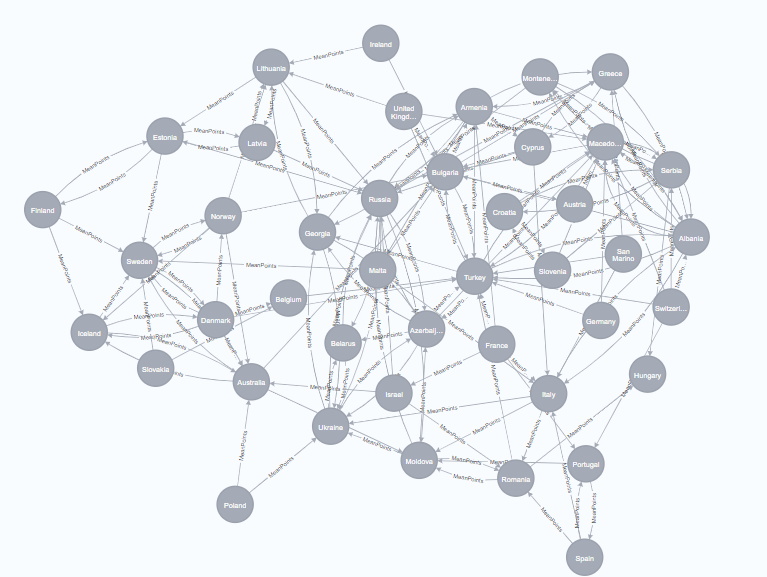

### Community Detection using Louvain (now using Mean Votes)

First, we are storing the graph

In [34]:
query_string = '''
CALL gds.graph.project(  

'myGraph6',  

'Country',  

{  

MeanPoints: {  

orientation: 'UNDIRECTED'  

}  

}, 
 

{  

relationshipProperties: toFloat('Connection')  

}  

) 

 
'''
conn.query(query_string, db='coradb')


[<Record nodeProjection={'Country': {'label': 'Country', 'properties': {}}} relationshipProjection={'MeanPoints': {'orientation': 'UNDIRECTED', 'aggregation': 'DEFAULT', 'type': 'MeanPoints', 'properties': {}}} graphName='myGraph6' nodeCount=46 relationshipCount=310 projectMillis=24>]

Storing the new communities in a dataframe

In [35]:
query_string = '''
CALL gds.louvain.stream('myGraph6')  

 
 

YIELD nodeId, communityId, intermediateCommunityIds  

 
 

RETURN gds.util.asNode(nodeId).name AS name, communityId, intermediateCommunityIds  

 
 

ORDER BY communityId ASC 
 
'''
conn.query(query_string, db='coradb')

group_unweighted_Mean = DataFrame([dict(_) for _ in conn.query(query_string, db='coradb')])
group_unweighted_Mean.head()

,name,communityId,intermediateCommunityIds
0,Estonia,8,None
1,Finland,8,None
2,Lithuania,8,None
3,Latvia,8,None
4,Ireland,8,None


# Next we compute year by year biases

These are calculated by taking the mean vote for a country by year and then calculating the mean difference between this value and country's vote over multiple years

In [48]:
url='https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/eurovision_song_contest_1975_2022.csv'
df = pd.read_csv(url)
relevantYears = [*range(2008,2023,1)]
df = df[df["Year"].isin(relevantYears)]
df = df[df["(semi-) final"] == 'f']
df = df[df['From country'] != df['To country']]
df2 = df.groupby(['To country', "Year"])['Points'].agg('mean').rename('MeanPoints').reset_index()
df = df.merge(df2, on = ['To country','Year'])
df['Diff'] = df['Points'] - df['MeanPoints']
df = df.groupby(['From country', 'To country'])['Diff'].agg('mean').rename('True_Bias').reset_index().sort_values('True_Bias')
df


,From country,To country,True_Bias
1413,Netherlands,Sweden,-4.038462
1541,Poland,Turkey,-4.025491
1807,Slovakia,Turkey,-3.840822
507,Cyprus,North Macedonia,-3.812500
1887,Spain,North Macedonia,-3.812500
...,...,...,...
898,Greece,Cyprus,9.834032
1741,Serbia,F.Y.R. Macedonia,10.268293
359,Bosnia & Herzegovina,F.Y.R. Macedonia,10.268293
1756,Serbia,Montenegro,10.871795


Above we can see that there is a strong bias for Andorra to vote for Spain as well as Serbia to vote for Montenegro.  While there is also a negative bias for Netherlands voting for Sweden and Poland for Turkey.

In [49]:
df.to_csv('yearBias.csv')

In [46]:
url='https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Data/eurovision_song_contest_1975_2022.csv'
df = pd.read_csv(url)
relevantYears = [*range(2008,2023,1)]
df = df[df["Year"].isin(relevantYears)]
df = df[df["(semi-) final"] == 'f']
df = df[df['From country'] != df['To country']]
df2 = df.groupby(['To country', "Year"])['Points'].agg('mean').rename('MeanPoints').reset_index()
df = df.merge(df2, on = ['To country', 'Year'])
df['Diff'] = df['Points'] - df['MeanPoints']

df.loc[df['Diff'] < 0, 'Diff'] = -1
df.loc[df['Diff'] > 0, 'Diff'] = 1

df = df.groupby(['From country', 'To country'])['Diff'].agg('sum').rename('Bias').reset_index().sort_values('Bias')
df

,From country,To country,Bias
1018,Iceland,Spain,-20.0
226,Azerbaijan,Germany,-19.0
1319,Moldova,Germany,-19.0
1273,Malta,Germany,-19.0
494,Cyprus,Germany,-18.0
...,...,...,...
495,Cyprus,Greece,15.0
1279,Malta,Italy,15.0
1019,Iceland,Sweden,15.0
744,Finland,Sweden,17.0


In [47]:
df.to_csv('countBias.csv')

# Song Sentiment Analysis <a name="sentiment"></a>


A sentiment analysis was conducted on the winning songs of the years 2010-2019, 2021 and 2022. 
Polarity scores for each year were calculated and then plotted. 

An interesting pattern that was noticed was the shift in the sentiments from early in the decade to later in the decade. In the first half of the decade, all the winning songs showcased a somewhat linear but staggered increase in sentiment through the course of the song, which in most cases ended with a positive sentiment. However, in the past few years, from around 2018, more negative sentiments were seen in the winning songs with most of them ending on a negative note. 

In [7]:
#Creating the function to calculate polarity 
def blob_sentiment(txt):
    sent = TextBlob(txt).sentiment.polarity
    return sent

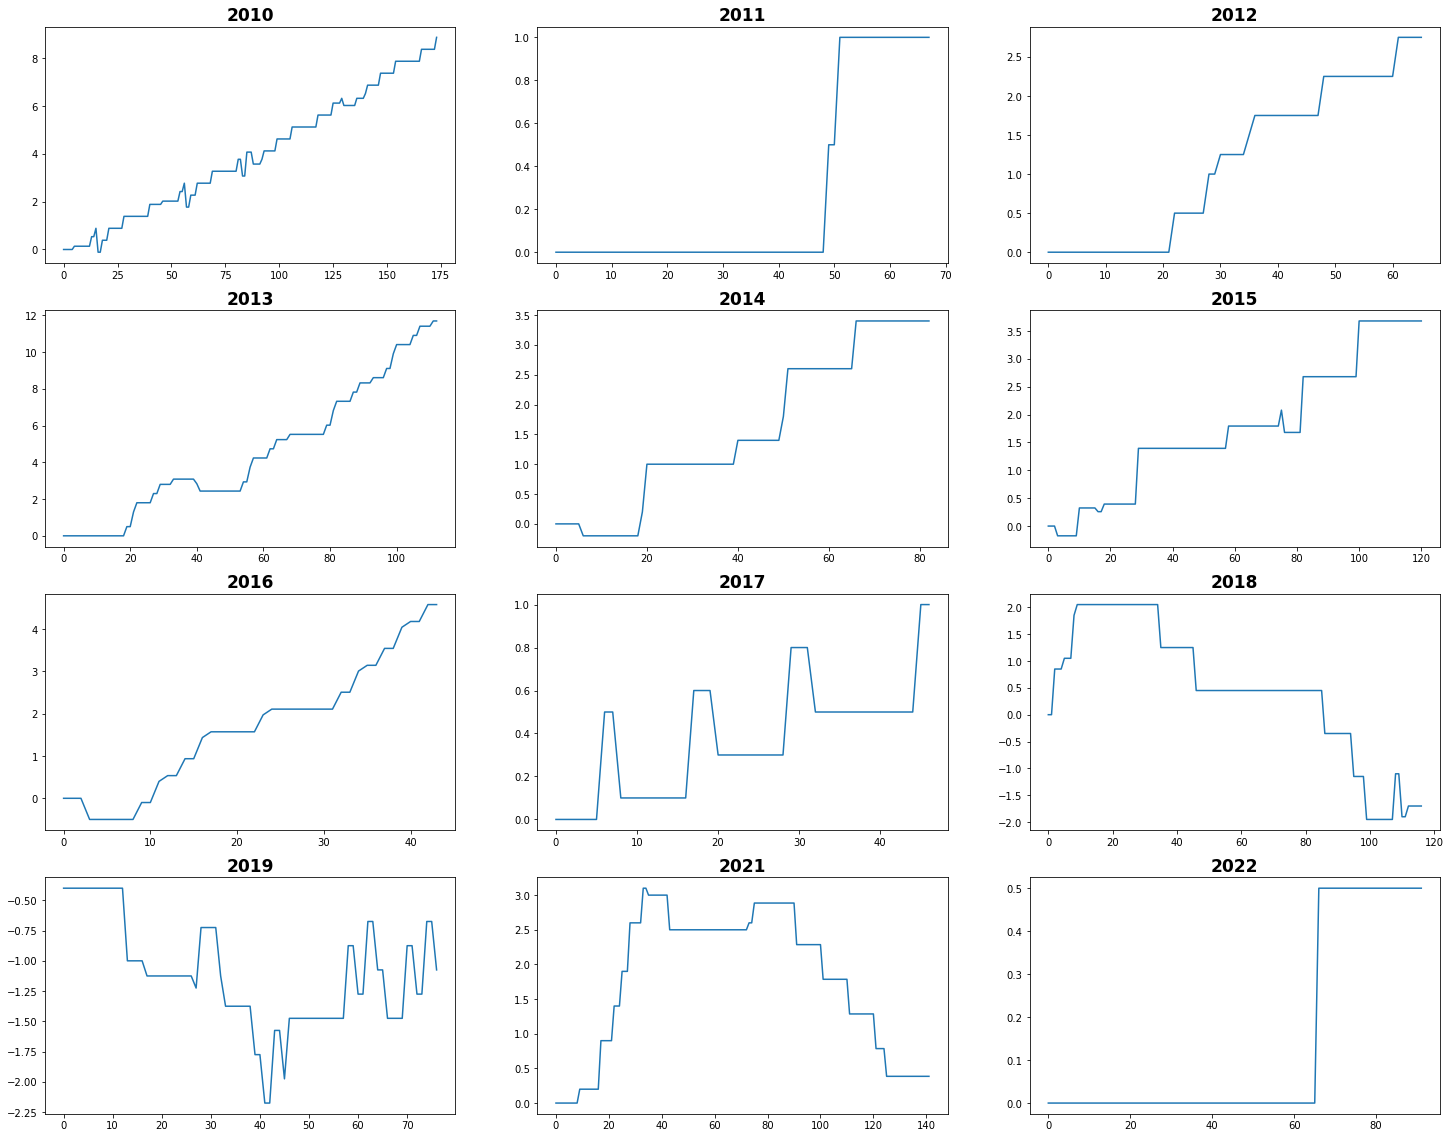

In [10]:
fig , ax = plt.subplots(4,3,figsize=(25,20))
grid_list = []

for row in range(0,4):
    for col in range(0,3):
        grid_list.append((row,col))
        
for y_id,year in enumerate(range(2010,2023)):
    if year==2020:
        continue
    else:
#         print(year)
        url="https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Lyrics%202/{}.txt".format(year)
        # read text file into pandas DataFrame
        df = requests.get(url)

        # display DataFrame
        text = df.text

        words = text.split()  
        alphabetic_only = [word for word in words if word.isalpha()]
        lower_case = [word.lower() for word in alphabetic_only]

        sw = stopwords.words('english')
        sw.append('oh') #adding the word 'oh' to the list of stopwords
        cleaned_words = [word for word in lower_case if word not in sw]

        df = pd.DataFrame(cleaned_words)
        df.columns = ['text']
        df['sentiment_blob'] = ''


        df['sentiment_blob'] = df['text'].apply(lambda x : blob_sentiment(x))

        if year in [2021,2022]:
            y_id-=1
        ax[grid_list[y_id]].plot(np.arange(0,len(df)),df['sentiment_blob'].cumsum(),label='Text Blob')
        ax[grid_list[y_id]].set_title(year,fontsize=17,fontweight='bold')


### Wordcloud Generation

A wordcloud was generated using the WordCloud function for the same set of winning songs through the years 2010-2019, 2020 and 2021. 
Since the analysis was done on song lyrics, the most frequently used words are usually the words found in either the title of the song or the chorus of the song. 
Another observation seen is that the word 'love' was commonly used in the early years of the decade. 


In [ ]:
fig , ax = plt.subplots(4,3,figsize=(25,20))

grid_list = []

for row in range(0,4):
    for col in range(0,3):
        grid_list.append((row,col))
        
for y_id,year in enumerate(range(2010,2023)):
    if year==2020:
        continue
    else:
#         print(year)
        url="https://raw.githubusercontent.com/jackmheller/modernDataAnalytics/main/Lyrics%202/{}.txt".format(year)
        # read text file into pandas DataFrame
        df = requests.get(url)

        text = df.text

        words = text.split()
        alphabetic_only = [word for word in words if word.isalpha()]
        lower_case = [word.lower() for word in alphabetic_only]

        sw = stopwords.words('english')
        sw.append('oh') #adding the word 'oh' to the list of stopwords
        cleaned_words = [word for word in lower_case if word not in sw]

        if year in [2021,2022]:
            y_id-=1
        unique_string=(" ").join(cleaned_words)
        wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
        ax[grid_list[y_id]].imshow(wordcloud)
        ax[grid_list[y_id]].axis("off")
        ax[grid_list[y_id]].set_title(year,fontsize=17,fontweight='bold')


# Predicting the 2022 Winner<a name="prediction"></a>

We have taken inspiration from the winner of the first Kaggle competition, who tried to [predict](https://web.archive.org/web/20160629205138/http://blog.kaggle.com/2010/06/09/computer-scientist-jure-zbontars-method-for-winning-the-eurovision-challenge/) the scores awarded by each country in the 2010 Eurovision Contest. 

We used the information on past voting and the approximate betting odds to predict the rankings for 2022. 

## Learning Voting Patterns

For predicting the rankings, we have used the past voting data from 1975-2021. We calculate the average points awarded by each country to each country to reveal voting patterns. We are using both jury and televoting numbers to reveal such patterns. Since we are only going to predict the winner, we will use only points awarded in the finals of each year for our analysis. 

In [34]:
#cleaning 1975-2019 data
esc_scores = pd.read_csv("https://github.com/jackmheller/modernDataAnalytics/blob/main/Data/eurovision_song_contest_1975_2022.csv?raw=true")
# esc_scores = pd.concat([esc_scores,esc_2021,esc_2022],ignore_index=True)

esc_scores_final = esc_scores.loc[esc_scores['(semi-) final'] == 'f']   #using only finals scores
esc_scores_final =  esc_scores_final.loc[esc_scores_final['Points'] != 0]  #removing 0 points 
esc_scores_final.replace(['F.Y.R. Macedonia', 'North Macedonia'], 'Macedonia', inplace = True)
esc_scores_final.replace(['The Netherands'], 'The Netherlands', inplace = True)

#calculating rankings for each year 
total_scores = esc_scores_final.groupby(['Year','To country']).sum().reset_index().sort_values(by=['Year','Points'],ascending=False)

urls_years = [2022,2021,2019,2018,2017,2016,2015]
true_rankings={}
for year in urls_years:
    true_rankings[year] = total_scores[total_scores['Year']==year]['To country'].tolist()

#calculate average scores 
avg_scores = esc_scores_final.groupby(['From country','To country']).mean().reset_index()
# avg_scores["Final Scores_with Odds"] = ' '
avg_scores = avg_scores.drop(columns=['Year'])


### Average scores awarded by Greece

Based on past voting data, Greece has awarded the most points on average to Cyprus - revealing a voting pattern that could be due to cultural and geographical reasons.

In [35]:
avg_scores[avg_scores['From country']=='Greece'].sort_values(by='Points',ascending=False)

,From country,To country,Unnamed: 0,Points,Duplicate
817,Greece,Cyprus,22343.366667,11.033333,NaN
827,Greece,Ireland,4222.727273,9.000000,NaN
836,Greece,Monaco,962.500000,8.000000,NaN
807,Greece,Albania,33161.083333,7.916667,NaN
815,Greece,Bulgaria,38368.833333,7.333333,NaN
808,Greece,Armenia,30294.800000,7.100000,NaN
845,Greece,Serbia & Montenegro,14920.000000,7.000000,NaN
821,Greece,Finland,10432.800000,6.500000,NaN
819,Greece,Denmark,10101.333333,6.500000,NaN
843,Greece,San Marino,49834.000000,6.500000,NaN


## Using Betting Odds 

Betting odds (here, we are using decimal odds) represent the amount of money one wins for every $1 wagered. The lower the betting odds for a country, the higher the probabilty that they are going to win. Betting odds data was scraped from eurovisionworld.com/odds/eurovision, we are only using the data from 2015 onwards.

In [36]:
#scraping the websites

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/101.0.4951.64 Safari/537.36'}
urls=['https://eurovisionworld.com/odds/eurovision','https://eurovisionworld.com/odds/eurovision-2021','https://eurovisionworld.com/odds/eurovision-2019','https://eurovisionworld.com/odds/eurovision-2018','https://eurovisionworld.com/odds/eurovision-2017','https://eurovisionworld.com/odds/eurovision-2016','https://eurovisionworld.com/odds/eurovision-2015']
urls_years = [2022,2021,2019,2018,2017,2016,2015]

def parse_table(url_list):
    
    odds_data = {}
    try:
        for url_id,url in enumerate(url_list):
            #Create a handle, page, to handle the contents of the website
            page = requests.get(url,headers=headers)

            #extracting table 

            # parser-lxml = Change html to Python friendly format
            # Obtain page's information
            soup = BeautifulSoup(page.text, 'lxml')

            # Obtain information from tag <table>
            table1 = soup.find('table', {"class":'o_table'})

            # Create a for loop to fill mydata
            data_set = []
            for i_j,j in enumerate(table1.find_all('tr')[1:]):
                if i_j>0:
                    row_data = j.find_all('td')
                    row = [i.text for i in row_data]
                    data_set.append(row)

            # Obtain every title of columns with tag <th>
            table_headers = []
            for i in table1.find_all('th'):
                title = i.text
                table_headers.append(title)

            #modifying headers manually
            if any(char.isdigit() for char in url.split("-")):
                if int(url.split("-")[-1]) == 2017:
                    header_prefix = ["Rank","Country","Song Name"]
                if int(url.split("-")[-1]) in [2016,2015]:
                    header_prefix = ["Rank","Song Name"]
            else:
                header_prefix = ["Rank","Country","Song Name","Winning Chance"]
            headers_final = header_prefix + table_headers[:table_headers.index('BETFAIREXCHANGE')+1]

            final_oddsdata = pd.DataFrame(data_set) #converting to df
            final_oddsdata.columns = headers_final #setting header names
            final_oddsdata.drop(final_oddsdata.tail(1).index,inplace=True) #removing last row

            #obtaining country name
            i=0
            for n in final_oddsdata['Song Name']:
                final_oddsdata.at[i, 'Country'] = n.split()[0]
                i+=1

            #manually correcting country names
            i=0
            for country in final_oddsdata['Country']:
                if country == 'UKUnited':
                    final_oddsdata.at[i, 'Country'] = 'United Kingdom'
                if country == 'Netherlands':
                    final_oddsdata.at[i, 'Country'] = 'The Netherlands'
                if country == 'Czech':
                    final_oddsdata.at[i, 'Country'] = 'Czech Republic'
                i+=1

            odds_data[urls_years[url_id]] = final_oddsdata

    except:
        print(url)
    return odds_data
    
all_urls_parsed = parse_table(urls) 

### Viewing 2022 Betting Odds

Ukraine had the lowest betting odds of 1.25 on BET365, which meant it had the highest probabilty of winning.
On the other hand, Lithuania had the lowest probability of winning, with betting odds of 1001. 

In [37]:
all_urls_parsed[2022]   #change year here to see different years' odds

,Rank,Country,Song Name,Winning Chance,BET365,UNIBET,888SPORT,BETFRED,COOLBET,WILLIAMHILL,...,BETWAY,BETFAIRSPORT,BOYLESPORTS,SMARKETS,SKYBET,10BET,COMEON,BETSTARS,BWIN,BETFAIREXCHANGE
0,1,Ukraine,Ukraine Kalush Orchestra - Stefania,62%,1.25,1.22,1.29,1.25,1.34,1.33,...,1.29,1.25,1.25,1.34,1.29,1.3,1.3,2.2,1.3,1.34
1,2,Sweden,Sweden Cornelia Jakobs - Hold Me Closer,14%,5,5.1,7.25,6.5,6,7,...,8,5.5,5.5,7.6,7,4.3,4.3,6.5,5,8
2,3,Spain,Spain Chanel - SloMo,6%,10,13,13,15,13,8,...,15,14,10,19,11,10,10,31,10,18
3,4,United Kingdom,UKUnited Kingdom Sam Ryder - Space Man,6%,13,15,8.75,13,15,13,...,7,10,11,22,12,12,12,18,15,25
4,5,Italy,Italy Mahmood & Blanco - Brividi,3%,41,51,14,34,37,34,...,15,23,41,55,34,41,41,4.33,34,55
5,6,Norway,Norway Subwoolfer - Give That Wolf a Banana,1%,101,101,73,67,81,101,...,67,23,41,200,67,41,41,21,67,210
6,7,Poland,Poland Ochman - River,1%,101,101,58,67,81,67,...,51,81,51,300,81,67,67,21,51,300
7,8,Serbia,Serbia Konstrakta - In Corpore Sano,1%,67,101,51,101,131,81,...,51,51,51,300,81,41,41,81,67,300
8,9,Greece,Greece Amanda Tenfjord - Die Together,1%,101,101,69,101,101,67,...,51,56,81,260,81,67,67,17,101,270
9,10,Moldova,Moldova Zdob şi Zdub & Advahov Brothers - Tre...,1%,151,81,101,51,81,81,...,67,71,67,230,51,67,67,151,101,160


### Modifying the Odds

The odds needed to be modified in order to be comparable to the average points using the following formula:

$odds = \frac{1}{log(odds)}*a + b$

$a$ and $b$ were chosen experimentally through cross-validation as detailed below.

In [38]:
#function to modify odds

def calc_odds(urls,a,b):
    
    #using only BET365
    odds_dict ={}
    for url_id,url in enumerate(urls):
        final_oddsdata = all_urls_parsed[urls_years[url_id]]
        odds = final_oddsdata[['Country','BET365']]
        odds.columns = ['Country','Odds']

        #converting odds to be comparable w avg points 
        recalc_odds=[]
        for odd in odds.Odds:
            o=float(odd)
            recalc_odds.append((1/np.log(o))*a + b)   
            
        odds.insert(2, "Modified_Odds", recalc_odds)

        odds_dict[urls_years[url_id]] = odds
        
    return odds_dict

### Evaluation Metrics

We are using Mean Squared Error (MSE) of the top-5 rankings to evaluate our predictions.

For choosing the parameters $a$ and $b$, we will iterate through every value within a range and calcuate the MSE at every step. The values that give us the minimum MSE will be used for our final predicitons. 

### Cross-Validation
For each year of the contest, the average scores are calculated without including that years' data so that we can evaluate the model's performance on unseen data. 

In [39]:
#function to calculate MSE of 
def MSE_predict(urls_years,odds_dict,cross_validating = True):
    
    predictions = {}
    total_MSE=0
    for year in urls_years:

        #removing current year from data if cross-validating
        if cross_validating:
            esc_scores_temp = esc_scores_final[esc_scores_final['Year']!=year]
        else:
            esc_scores_temp = esc_scores_final[esc_scores_final['Year']<2022]
        #calculate average scores 
        avg_scores_temp = esc_scores_temp.groupby(['From country','To country']).mean().reset_index()
        avg_scores_temp["Final Scores_with Odds"] = ' '


        odds = odds_dict[year]
        #adding avg scores recevied with odds for each country
        for i,p in enumerate(avg_scores_temp['Points']):
            country = avg_scores_temp.loc[i,'To country']
            if country in list(odds.Country):
                odd = odds['Modified_Odds'][odds['Country']==country]
                avg_scores_temp.at[i,"Final Scores_with Odds"] = p + float(odd)
            else:
                avg_scores_temp.at[i,"Final Scores_with Odds"] = 0

        avg_scores_temp = avg_scores_temp.astype({'Final Scores_with Odds': 'float64'})

        #summing all points received for each country
        final_score_prediction = avg_scores_temp.groupby(['To country']).sum()
        final_score_prediction = final_score_prediction.sort_values(by=['Final Scores_with Odds'],ascending=False)
        
        predictions[year] = final_score_prediction.index.tolist()
        y_true = []
        y_pred = []
        for i,t in enumerate(true_rankings[year]):
            if t in final_score_prediction.index.tolist():
                y_true.append(i)
                y_pred.append(final_score_prediction.index.tolist().index(t))
        mse = mean_squared_error(y_true[:5], y_pred[:5])   #mse for top 5 rankings only 
        
        if not cross_validating:
            print("MSE for {} = {}".format(year,mse ))
        total_MSE+=mse
        
    if not cross_validating:  
        print("Total MSE for all years = {}".format(total_MSE))
        print("Average MSE for all years = {}".format(total_MSE/len(urls_years)))
    
    return total_MSE,predictions

In [ ]:
#cross validation to find odds parameters:

all_parameters=[]
for a in range(-10,10):
    for b in np.arange(-3,3,.2):
        odds_dict = calc_odds(urls,a,b)
        total_MSE,p = MSE_predict(urls_years[1:],odds_dict)      

        all_parameters.append([a,b,total_MSE,total_MSE/len(urls_years)])

### Choosing $a$ and $b$ 

We found that $a=9$ and $b=-3$ gave us the lowest total MSE.

In [ ]:
print("Parameters with minimum total MSE-")

print("[a, b, Total MSE, Average MSE] = {}".format(all_parameters[np.argmin(np.array(all_parameters),axis=0)[2]]))

In [30]:
odds_dict = calc_odds(urls,9,2.4)

### MSE for each year's predictions

The model predicts the rankings for most years with relatively low MSE, expect for 2017 and 2018. 

In 2017, it was due to Moldova's unexpected 3rd place ranking, for which the model predicted a rank of 15.
While in 2018, it was due to Austria's 3rd place ranking, for which the model predicted a rank of 21. 

In [31]:
total_MSE,predictions = MSE_predict(urls_years,odds_dict,cross_validating=False)

MSE for 2022 = 11.6
MSE for 2021 = 2.8
MSE for 2019 = 127.0
MSE for 2018 = 45.6
MSE for 2017 = 28.8
MSE for 2016 = 14.6
MSE for 2015 = 0.2
Total MSE for all years = 230.6
Average MSE for all years = 32.94285714285714


### 2022 Predictions

Our model correctly predicts the winner for 2021, Ukraine. However, this is not suprising since Ukraine had such high probabilty of winning as encapsulated by the betting odds. 

Below, we see the predicted Top 5 rankings for Eurovision 2022. 

In [24]:
print("Predicted Top 5:", predictions[2022][:5])
print("Actual Top 5:", true_rankings[2022][:5])

Predicted Top 5: ['Ukraine', 'Sweden', 'United Kingdom', 'Italy', 'Spain']
Actual Top 5: ['Ukraine', 'United Kingdom', 'Spain', 'Sweden', 'Serbia']


In [26]:
predictions[2019][:5]

['Italy', 'Switzerland', 'Sweden', 'Australia', 'Russia']

In [27]:
true_rankings[2019][:5]

['Netherlands', 'Italy', 'Russia', 'Switzerland', 'Sweden']

In [33]:
odds_dict[2019]

,Country,Odds,Modified_Odds
0,The Netherlands,1.5,24.596731
1,Italy,5,7.992014
2,Switzerland,6,7.422996
3,Australia,11,6.153292
4,Sweden,15,5.723424
5,Norway,34,4.952206
6,Azerbaijan,34,4.952206
7,Russia,41,4.823543
8,Iceland,51,4.689013
9,France,67,4.540466
